In [1]:
from diffusers import DDPMScheduler
import torch
from torch import nn
from torch.distributions import Dirichlet, Normal, MixtureSameFamily, Categorical
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from tqdm import tqdm

/home/roko/.cache/pypoetry/virtualenvs/diff-i93oUBlF-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ScoreNetwork(nn.Module):
    def __init__(self, data_dim, latent_dim, time_steps=10000):
        super().__init__()
        self.data_dim = data_dim
        self.latent_dim = latent_dim
        self.time_steps = time_steps
        self.t_embed_dim = 64
        self.theta_embed_dim = max(30, 4 * self.latent_dim)
        self.x_embed_dim = max(30, 4 * data_dim)

        self.theta_network = nn.Sequential(
            nn.Linear(self.latent_dim, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, self.theta_embed_dim)
        )

        self.x_network = nn.Sequential(
            nn.Linear(self.data_dim, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, self.x_embed_dim)
        )

        self.output_network = nn.Sequential(
            nn.Linear(self.t_embed_dim + self.theta_embed_dim + self.x_embed_dim, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, self.latent_dim)
        )

    def get_timestep_embedding(self, timesteps, embedding_dim, max_positions=10000):
        half_dim = embedding_dim // 2
        time_embedding = torch.log(torch.tensor([max_positions])) / (half_dim - 1)
        time_embedding = torch.exp(torch.arange(half_dim) * -time_embedding)
        time_embedding = timesteps[:, None] * time_embedding[None, :]
        return torch.cat((torch.sin(time_embedding), torch.cos(time_embedding)), dim=1)
    
    def forward(self, t, theta_t, x_obs):
        time_embedding = self.get_timestep_embedding(t, self.t_embed_dim)
        theta_embedding = self.theta_network(theta_t)
        x_embedding = self.x_network(x_obs)
        out = self.output_network(torch.cat((time_embedding, theta_embedding, x_embedding), dim=1))
        return out
        

In [3]:
train_data_size = 10000

alpha = torch.tensor([0.1, 1.0, 2.0])
dirichlet = Dirichlet(alpha)
weights = dirichlet.sample(sample_shape=[train_data_size])

num_clusters = 3
loc = torch.tensor([10.0, 11.0, 12.0]).expand([train_data_size, -1])
scale = torch.tensor([1.0, 1.0, 1.0]).expand([train_data_size, -1])

data_dim = 1
normal = Normal(loc, scale)
mixture = MixtureSameFamily(Categorical(weights), normal)

sample = mixture.sample()

In [4]:
# Convert the sample and weights to tensors if not already
sample = torch.stack(sample) if not torch.is_tensor(sample) else sample
weights = torch.stack(weights) if not torch.is_tensor(weights) else weights

# Create a dataset from the sample and weights
class MixtureDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        if self.data.dim() == 1:
            self.data = self.data.unsqueeze(1)
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Initialize the dataset and dataloader
training_data = MixtureDataset(sample, weights)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [5]:
def ScoreMatching(score_pred, epsilon, sd):
    return torch.mean( (score_pred + epsilon / sd) ** 2)

# Initialize model, optimizer, loss function, and noise scheduler
latent_denoiser = ScoreNetwork(data_dim=data_dim, latent_dim=num_clusters)
optimizer = torch.optim.Adam(latent_denoiser.parameters(), lr=1e-4)
loss_fn = ScoreMatching

num_train_timesteps = 1000
noise_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)

losses = []
# Training loop with tqdm
for epoch in range(1, 2500):
    total_loss = 0
    pbar = tqdm(train_dataloader, desc=f'Epoch {epoch}')
    for sample, weight_vector in pbar:
        data_dim = sample.shape[-1]
        batch_dim, cluster_dim = weight_vector.shape

        epsilon = torch.randn_like(weight_vector)
        sampled_ts = noise_scheduler.timesteps[torch.randint(0, num_train_timesteps, size=(batch_dim,))]
        theta_t = noise_scheduler.add_noise(weight_vector, epsilon, sampled_ts)
        
        score_pred = latent_denoiser(sampled_ts, theta_t, sample)
        
        retrieved_sds = torch.sqrt(1 - noise_scheduler.alphas_cumprod[sampled_ts])[:, None]
        loss = loss_fn(score_pred, epsilon, retrieved_sds)
        
        optimizer.zero_grad()
        loss.backward()
        pbar.set_postfix({'loss': f'{round(loss.item(), 3)}'})
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_dataloader)
    losses.append(round(avg_loss, 3))
    pbar.set_postfix({'avg_loss': f'{avg_loss:.3f}'})

Epoch 2139:  97%|█████████▋| 152/157 [00:01<00:00, 126.22it/s, loss=1.49]   


KeyboardInterrupt: 

Text(0, 0.5, '$(\\hat{s} - \\nabla{\\theta_t}\\log p_{t\\mid 0}(\\theta_t \\mid \\theta_0))^2$')

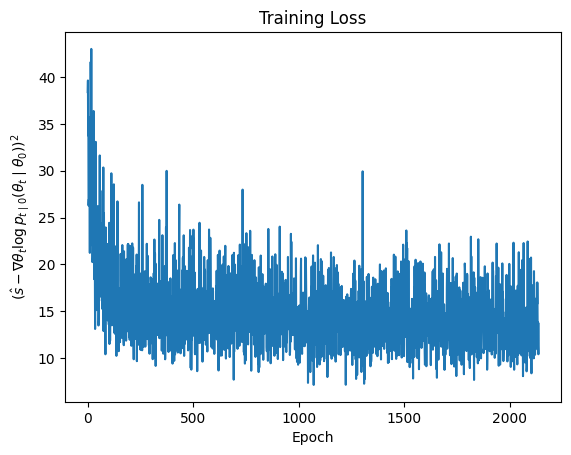

In [6]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel(r"$(\hat{s} - \nabla{\theta_t}\log p_{t\mid 0}(\theta_t \mid \theta_0))^2$")

In [ ]:
test_data_size = 100

alpha = torch.tensor([0.1, 1.0, 2.0])
dirichlet = Dirichlet(alpha)
weight_test = dirichlet.sample(sample_shape=[test_data_size])

loc = torch.tensor([10.0, 11.0, 12.0]).expand([test_data_size, -1])
scale = torch.tensor([1.0, 1.0, 1.0]).expand([test_data_size, -1])
normal = Normal(loc, scale)
mixture = MixtureSameFamily(Categorical(weight_test), normal)

sample = mixture.sample()

testing_data = MixtureDataset(sample, weights)

test_dataloader = DataLoader(testing_data, batch_size=10, shuffle=True)

for x_test, test_weight_vector in test_dataloader:

    theta_flow = [torch.randn_like(test_weight_vector)]
    reconstruction_loss = []

    batch_size, latent_dim = test_weight_vector.shape

    for t, time in enumerate(noise_scheduler.timesteps):
        
        t_tensor = torch.tensor([time])  # Current timestep as a tensor
        score_pred = latent_denoiser(t_tensor.expand([batch_size]), theta_flow[-1], x_test)
        sigma_t = torch.sqrt(1 - noise_scheduler.alphas_cumprod[-t])

        theta_t_next = theta_flow[-1] - 0.5 * (sigma_t ** 2) * score_pred

        theta_flow.append(theta_t_next)

        reconstruction_loss.append(nn.MSELoss()(theta_t_next, test_weight_vector).item())

        if torch.isnan(theta_t_next).any():
            print(f"NaNs detected at timestep {t}")
            break

In [26]:
test_data_size = 100

alpha = torch.tensor([0.1, 1.0, 2.0])
dirichlet = Dirichlet(alpha)
weight_test = dirichlet.sample(sample_shape=[test_data_size])

loc = torch.tensor([10.0, 11.0, 12.0]).expand([test_data_size, -1])
scale = torch.tensor([1.0, 1.0, 1.0]).expand([test_data_size, -1])
normal = Normal(loc, scale)
mixture = MixtureSameFamily(Categorical(weight_test), normal)

sample = mixture.sample()

testing_data = MixtureDataset(sample, weights)

test_dataloader = DataLoader(testing_data, batch_size=10, shuffle=True)

# Using the noise scheduler and defined number of timesteps (T)
num_train_timesteps = noise_scheduler.num_train_timesteps  # e.g., 1000

for x_test, test_weight_vector in test_dataloader:
    batch_size, latent_dim = test_weight_vector.shape
    
    # Initialize theta at t=T with noise (θ_T ∼ π(·))
    theta = torch.randn_like(test_weight_vector)
    
    # Reverse process: move from t=T down to t=0
    for t in reversed(range(num_train_timesteps)):
        t_tensor = torch.full((batch_size,), t, dtype=torch.long)
        
        # Predict the score at the current timestep
        score_pred = latent_denoiser(t_tensor, theta, x_test)

        # Compute the standard deviation (sigma) for the current timestep
        # sigma_t^2 = (1 - alpha_t_cumprod)
        sigma_t = torch.sqrt(1 - noise_scheduler.alphas_cumprod[t])
        
        # Probability Flow ODE for a discrete timestep scenario:
        # θ_{t-1} = θ_t - 1/2 * sigma_t^2 * score_pred * delta
        # We approximate delta as 1/num_train_timesteps for discrete steps
        drift = (sigma_t ** 2) * score_pred 
        noise = sigma_t * torch.randn_like(theta)
        theta = theta - drift - noise
        
        if torch.isnan(theta).any():
            print(f"NaNs detected at timestep {t}")
            break
    
        # After reversing to t=0, evaluate the reconstruction
        reconstruction_loss = nn.MSELoss()(theta, test_weight_vector)
        print(f"Reconstruction Loss at {t}: {reconstruction_loss.item():.4f}")


Reconstruction Loss at 999: 5.5314
Reconstruction Loss at 998: 28.8669
Reconstruction Loss at 997: 2615.6670
Reconstruction Loss at 996: 9226994.0000
Reconstruction Loss at 995: 15471736832.0000
Reconstruction Loss at 994: 12643149545472.0000
Reconstruction Loss at 993: 8349388506136576.0000
Reconstruction Loss at 992: 4888987798754820096.0000
Reconstruction Loss at 991: 2488431604481245839360.0000
Reconstruction Loss at 990: 1332839517086763873992704.0000
Reconstruction Loss at 989: 735641912773112014672232448.0000
Reconstruction Loss at 988: 410099939000025044433596579840.0000
Reconstruction Loss at 987: 229626948598028724746048199720960.0000
Reconstruction Loss at 986: 128791142015759593488865621593554944.0000
Reconstruction Loss at 985: inf
Reconstruction Loss at 984: inf
Reconstruction Loss at 983: inf
Reconstruction Loss at 982: inf
Reconstruction Loss at 981: inf
Reconstruction Loss at 980: inf
Reconstruction Loss at 979: inf
Reconstruction Loss at 978: inf
Reconstruction Loss a

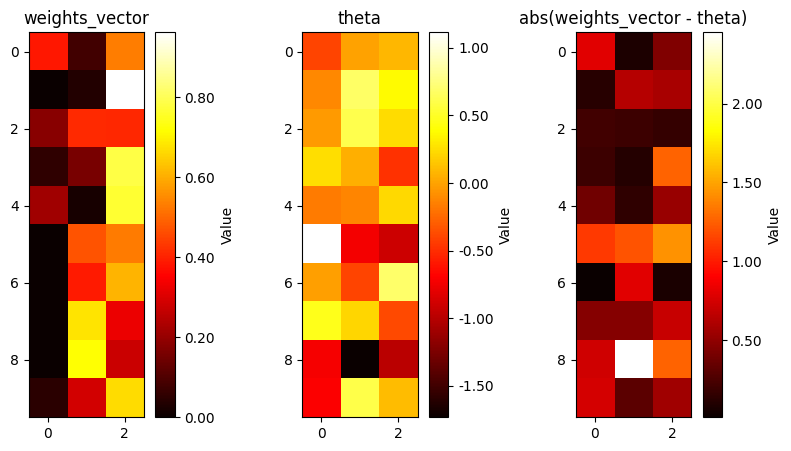

In [19]:
import matplotlib.pyplot as plt

# Plot the weights_vector heatmap
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('weights_vector')
im1 = plt.imshow(test_weight_vector.detach().numpy(), cmap='hot', interpolation='nearest')
plt.colorbar(im1, label='Value', format='%.2f')

# Plot the theta heatmap
plt.subplot(1, 3, 2)
plt.title('theta')
im2 = plt.imshow(theta.detach().numpy(), cmap='hot', interpolation='nearest')
plt.colorbar(im2, label='Value', format='%.2f')

# Plot the absolute difference heatmap
plt.subplot(1, 3, 3)
plt.title('abs(weights_vector - theta)')
im3 = plt.imshow(torch.abs(test_weight_vector - theta).detach().numpy(), cmap='hot', interpolation='nearest')
plt.colorbar(im3, label='Value', format='%.2f')

plt.show()
